In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
from pathlib import Path

if __name__ == "__main__":
    __this_file = Path().resolve() / "ddqn.ipynb"  # jupyter does not have __file__

In [3]:
import torch

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if __name__ == "__main__":
    print(DEVICE)

cpu


In [4]:
from torch import nn

from continuing_education.policy_gradient_methods.reinforce import Action, State, Env
import random

In [40]:
from continuing_education.value_based_methods.dqn.dqn import QLearningModel
from enum import Enum

class AdvantageType(str, Enum):
    AVG = "avg"
    MAX = "max"
    
class DuelingQLearningModel(QLearningModel):
    def __init__(
        self, *, 
        state_size: int, 
        action_size: int, 
        hidden_sizes: list[int], 
        advantage_hidden_sizes: list[int], 
        value_hidden_sizes: list[int],
        adv_type: AdvantageType,
    ) -> None:
        """
        Notice that this is exactly the same as the Policy network from REINFORCE, because
        we are still starting from the state and outputting an action. The difference is that
        we will not softmax the output, because its not a probability distribution, but rather
        a regressor that outputs the Q value of each action.
        """
        super().__init__(state_size=state_size, action_size=action_size, hidden_sizes=hidden_sizes)
        assert len(hidden_sizes) > 0, "Need at least one hidden layer"
        assert len(advantage_hidden_sizes) > 0, "Need at least one advantage hidden layer"
        assert len(value_hidden_sizes) > 0, "Need at least one value hidden layer"
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_sizes = hidden_sizes
        self.advantage_hidden_sizes = advantage_hidden_sizes
        self.value_hidden_sizes = value_hidden_sizes
        self.adv_type = adv_type

        # Dimensions in the network are (batch_size, input_size, output_size)
        network: list[nn.Module] = []
        network.append(
            nn.Linear(state_size, hidden_sizes[0])
        )  # Shape: (:, state_size, hidden_sizes[0])
        network.append(nn.ReLU())
        for i in range(len(hidden_sizes) - 1):
            network.append(
                nn.Linear(hidden_sizes[i], hidden_sizes[i + 1])
            )  # Shape: (:, hidden_sizes[i], hidden_sizes[i+1])
            network.append(nn.ReLU())
        self.network = nn.Sequential(*network).to(DEVICE)

        # Now we are going to split into the value and advantage branches
        # Advantage Network
        advantage_network: list[nn.Module] = []
        advantage_network.append(nn.Linear(hidden_sizes[-1], advantage_hidden_sizes[0])) # Shape: (:, hidden_sizes[-1], advantage_hidden_sizes[0])
        advantage_network.append(nn.ReLU())
        for i in range(len(advantage_hidden_sizes) - 1):
            advantage_network.append(nn.Linear(advantage_hidden_sizes[i], advantage_hidden_sizes[i + 1])) # Shape: (:, advantage_hidden_sizes[i], advantage_hidden_sizes[i + 1])
            advantage_network.append(nn.ReLU())
        advantage_network.append(nn.Linear(advantage_hidden_sizes[-1], action_size))  # Shape: (:, advantage_hidden_sizes[-1], action_size)
        self.advantage_network = nn.Sequential(*advantage_network).to(DEVICE)
        
        # Value Network
        value_network: list[nn.Module] = []
        value_network.append(nn.Linear(hidden_sizes[-1], value_hidden_sizes[0])) # Shape: (:, hidden_sizes[-1], value_hidden_sizes[0])
        value_network.append(nn.ReLU())
        for i in range(len(advantage_hidden_sizes) - 1):
            value_network.append(nn.Linear(value_hidden_sizes[i], value_hidden_sizes[i + 1])) # Shape: (:, value_hidden_sizes[i], value_hidden_sizes[i + 1])
            value_network.append(nn.ReLU())
        value_network.append(nn.Linear(value_hidden_sizes[-1], 1))  # Shape: (:, value_hidden_sizes[-1], 1)
        self.value_network = nn.Sequential(*value_network).to(DEVICE)
        

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Takes a state tensor and returns logits along the action space"""
        state = state.to(DEVICE)
        network_out = self.network(state)
        advantage_out = self.advantage_network(network_out)
        value_out = self.value_network(network_out)

        # These "recreate" the Q function via a value function and an advantage function
        if self.adv_type == AdvantageType.AVG:
          advAverage = torch.mean(advantage_out, dim=1, keepdim=True)
          q =  value_out + advantage_out - advAverage
        elif self.adv_type == AdvantageType.MAX:
          advMax,_ = torch.max(advantage_out, dim=1, keepdim=True)
          q =  value_out + advantage_out - advMax
        else:
            raise KeyError(f"{self.adv_type} not recognized")
        return q

In [41]:
from continuing_education.policy_gradient_methods.reinforce.reinforce import MockEnv
from continuing_education.value_based_methods.dqn.dqn import dqn_train, objective, ActionReplayMemory
from torch import optim

def test_ddqn_train() -> None:
    """Test the reinforce training loop on the mock environment."""
    env = MockEnv(max_steps=10)
    value_network = DuelingQLearningModel(
        state_size=1,
        action_size=2,
        hidden_sizes=[16, 16],
        advantage_hidden_sizes=[16],
        value_hidden_sizes=[16],
        adv_type=AdvantageType.MAX
    )
    optimizer = optim.Adam(value_network.parameters(), lr=1e-3)
    memory = ActionReplayMemory(max_size=1000)
    scores = dqn_train(
        env=env,
        value_network=value_network,
        optimizer=optimizer,
        memory=memory,
        gamma=0.999,
        num_episodes=100,
        max_t=10,
        batch_size=50,
        exploration_rate_decay=0.96,
    )
    assert all([score == 10 for score in scores[90:]]), (
        f"The last 10 scores should be 10, got: {scores[90:]}"
    )


if __name__ == "__main__":
    for _ in range(3):
        test_ddqn_train()
        print("test_ddqn_train passed")

  0%|          | 0/100 [00:00<?, ?it/s]

AssertionError: The last 10 scores should be 10, got: [10, 10, 10, 10, 10, 10, 10, 8, 10, 10]

In [ ]:
from continuing_education.policy_gradient_methods.reinforce.reinforce import (
    get_environment_space,
)


if __name__ == "__main__":
    OBSERVATION_SPACE_SHAPE, ACTION_SPACE_SIZE = get_environment_space("CartPole-v1")

Lastly, because Q Learning can not learn stochastic policies, we need to incentivize the network to explore during training or else we will not learn a good value function. We do this by adding noise to the action selection during training, and reducing it over time. This is called epsilon greedy exploration. We will start with an epsilon of 1, meaning we will always take a random action, and decay it to 0 exponentially over the course of training. You want to pick a discount factor which converges to 0 just before the end of training usually.

  0%|          | 0/500 [00:00<?, ?it/s]

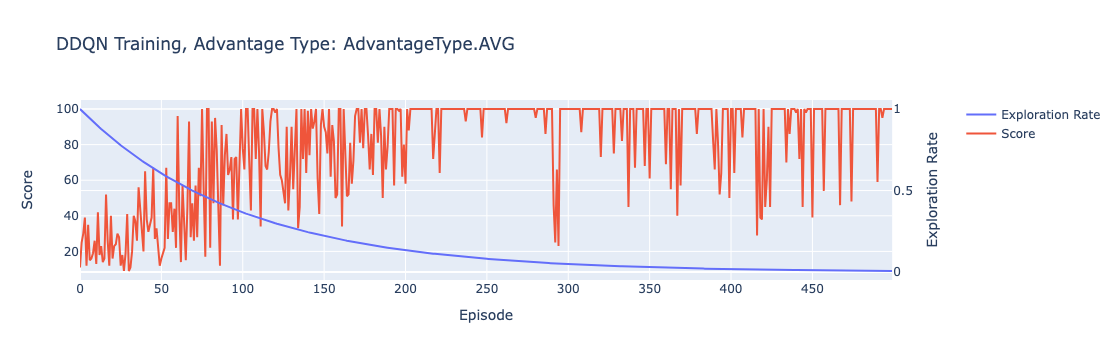

  0%|          | 0/500 [00:00<?, ?it/s]

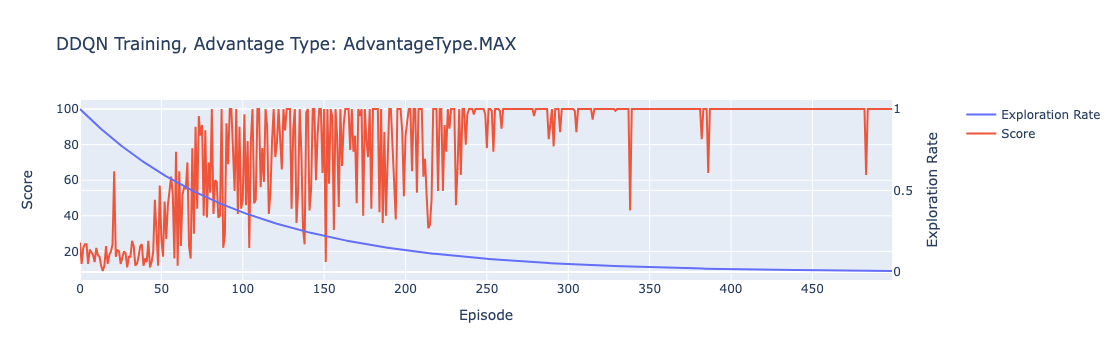

  0%|          | 0/500 [00:00<?, ?it/s]

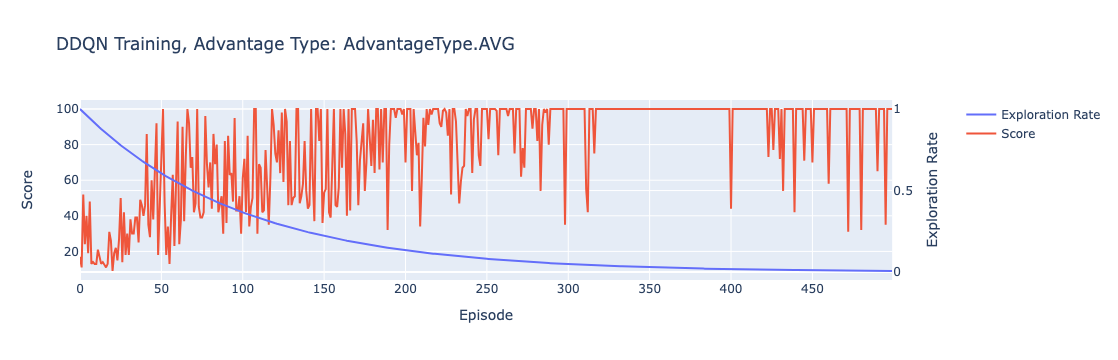

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
import gym
from continuing_education.lib.experiments import ExperimentManager
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from continuing_education.value_based_methods.dqn.dqn import exploration_rate_line

if __name__ == "__main__":
    LR = 1e-3
    GAMMA = 0.99999  # Cartpole benefits from a high gamma because the longer the pole is up, the higher the reward
    HIDDEN_SIZES = [16, 16]
    ADVANTAGE_HIDDEN_SIZES = [16]
    VALUE_HIDDEN_SIZES = [16]
    NUM_EPISODES = 500
    MAX_T = 100
    BATCH_SIZE = 64
    MAX_MEMORY = 10000
    EXPLORE_RATE_DECAY = 0.99
    # Do this a few times to prove consistency
    last_10_percent_mean = []

    for _ in range(3):
        for adv_type in [AdvantageType.AVG, AdvantageType.MAX]:
            env = gym.make("CartPole-v1")
            value_network = DuelingQLearningModel(
                state_size=OBSERVATION_SPACE_SHAPE[0],
                action_size=ACTION_SPACE_SIZE,
                hidden_sizes=HIDDEN_SIZES,
                advantage_hidden_sizes=ADVANTAGE_HIDDEN_SIZES,
                value_hidden_sizes=VALUE_HIDDEN_SIZES,
                adv_type=adv_type
            ).to(DEVICE)
            optimizer = optim.Adam(value_network.parameters(), lr=LR)
            scores = dqn_train(
                env=env,
                value_network=value_network,
                optimizer=optimizer,
                gamma=GAMMA,
                num_episodes=NUM_EPISODES,
                max_t=MAX_T,
                memory=ActionReplayMemory(MAX_MEMORY),
                batch_size=BATCH_SIZE,
                exploration_rate_decay=EXPLORE_RATE_DECAY,
            )
            # Calculate the mean of the last 10 % of the scores
            last_10_percent_mean.append(
                sum(scores[int(NUM_EPISODES * 0.9) :]) / (NUM_EPISODES * 0.1)
            )
            _exploration_rate_line = exploration_rate_line(
                explore_rate_decay=EXPLORE_RATE_DECAY,
                start_value=1.0,
                num_episodes=NUM_EPISODES,
            )
            fig = make_subplots(specs=[[{"secondary_y": True}]])
            fig.add_trace(
                go.Scatter(
                    x=[i for i in range(NUM_EPISODES)],
                    y=_exploration_rate_line,
                    name="Exploration Rate",
                    mode="lines",
                ),
                secondary_y=True,
            )
            fig.add_trace(
                go.Scatter(
                    x=[i for i in range(NUM_EPISODES)], y=scores, name="Score", mode="lines"
                ),
                secondary_y=False,
            )
            fig.update_layout(title=f"DDQN Training, Advantage Type: {adv_type}")
            fig.update_xaxes(title_text="Episode")
            fig.update_yaxes(title_text="Exploration Rate", secondary_y=True)
            fig.update_yaxes(title_text="Score", secondary_y=False)
            fig.show()
    ExperimentManager(
        name="DDQN",
        description="Main Results",
        primary_metric="last_10_percent_mean",
        file=__this_file,
    ).commit(metrics={"last_10_percent_mean": last_10_percent_mean})

# References

1. https://www.youtube.com/watch?v=wDVteayWWvU&t=371s
2. https://medium.com/@sainijagjit/understanding-dueling-dqn-a-deep-dive-into-reinforcement-learning-575f6fe4328c